In [1]:
import sys
sys.path.insert(0, f'D:/OneDrive/Program/GitHub/EasyIDP')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

In [3]:
project_name = 'broccoli_tanashi_5_20200528_P4M_10m_before'
project_path = f"Z:/共享云端硬盘/broccoliProject/tanashi_broccoli2020_RGB_AP/{project_name}"
raw_img_folder=f"Z:/共享云端硬盘/broccoliProject/rgb_raw/{project_name}"
label_folder = f"Z:/共享云端硬盘/broccoliProject/pred_bbox_nms_0.3/{project_name}/labels"
param_folder = f"{project_path}/params"

In [4]:
p4d = Pix4D(project_path=project_path, 
            raw_img_path=raw_img_folder, 
            project_name=project_name,
            param_folder=param_folder)

[Init][Pix4D] No ply given, however find 'broccoli_tanashi_5_20200528_P4M_10m_before_group1_densified_point_cloud.ply' at current project folder
[Init][Pix4D] No dom given, however find 'broccoli_tanashi_5_20200528_P4M_10m_before_transparent_mosaic_group1.tif' at current project folder
[Init][Pix4D] No dsm given, however find 'broccoli_tanashi_5_20200528_P4M_10m_before_dsm.tif' at current project folder
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]


In [5]:
from easyric.caas_lite import TiffSpliter

grid_len = 1300
buffer_len = 200

In [6]:
ts = TiffSpliter(tif_path=p4d.dom_file, grid_h=grid_len, grid_w=grid_len, grid_buffer=buffer_len)

# read labels to python

In [7]:
import os

In [8]:
label_list = os.listdir(label_folder)
label_list[:10]

['grid_x13_y06.txt',
 'grid_x12_y13.txt',
 'grid_x12_y10.txt',
 'grid_x13_y09.txt',
 'grid_x12_y15.txt',
 'grid_x13_y05.txt',
 'grid_x13_y10.txt',
 'grid_x13_y07.txt',
 'grid_x12_y16.txt',
 'grid_x12_y11.txt']

In [9]:
x_id, y_id = ts.name2id(label_list[0], 'txt')
x_id, y_id

(13, 6)

In [10]:
ts.wgrid_st[x_id], ts.hgrid_st[y_id]

(16900, 7800)

In [11]:
bbox_pd = pd.DataFrame(columns=['offset_x', 'offset_y', 
                                'xc', 'yc', 'w', 'h', 
                                'thresh'])

for label_txt in label_list:
    print(f"reading {label_txt}", end="\r")
    with open(f"{label_folder}/{label_txt}") as f:
        x_id, y_id = ts.name2id(label_txt, 'txt')
        offset_x, offset_y = ts.wgrid_st[x_id], ts.hgrid_st[y_id]
        for l in f.readlines():
            _, xc, yc, w, h, thresh = l.split(' ')

            bbox_pd.loc[len(bbox_pd),:] = [offset_x, offset_y, 
                                           float(xc), float(yc),
                                           float(w), float(h), float(thresh)]

In [34]:
bbox_pd.dtypes

offset_x    object
offset_y    object
xc          object
yc          object
w           object
h           object
thresh      object
dtype: object

In [35]:
bbox = bbox_pd.astype(np.float32)

In [36]:
bbox['xc'] = bbox['xc'] * (grid_len + buffer_len)
bbox['yc'] = bbox['yc'] * (grid_len + buffer_len)
bbox['w']  = bbox['w'] * (grid_len + buffer_len)
bbox['h']  = bbox['h'] * (grid_len + buffer_len)

bbox['x0'] = bbox['xc'] - bbox['w'] / 2
bbox['x1'] = bbox['xc'] + bbox['w'] / 2
bbox['y0'] = bbox['yc'] - bbox['h'] / 2
bbox['y1'] = bbox['yc'] + bbox['h'] / 2

bbox

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,y1
0,16900.0,7800.0,7.000005,574.500000,13.999995,52.999947,0.424072,0.000008,14.000003,548.000000,601.000000
1,16900.0,7800.0,161.500504,139.999939,52.999947,82.000053,0.642090,135.000534,188.000473,98.999908,180.999969
2,16900.0,7800.0,435.499512,1462.999512,52.999947,40.000050,0.646973,408.999542,461.999481,1442.999512,1482.999512
3,16900.0,7800.0,114.000000,20.500050,67.999947,39.000000,0.687988,80.000031,147.999969,1.000050,40.000050
4,16900.0,7800.0,82.500000,1092.000000,57.000000,48.000004,0.712891,54.000000,111.000000,1068.000000,1116.000000
...,...,...,...,...,...,...,...,...,...,...,...
9930,5200.0,15600.0,689.500488,694.000488,69.000000,66.000000,0.806641,655.000488,724.000488,661.000488,727.000488
9931,5200.0,15600.0,139.500000,1012.500000,70.999947,61.000050,0.809570,104.000031,174.999969,982.000000,1043.000000
9932,5200.0,15600.0,222.499496,1398.000000,55.000050,46.000050,0.811523,194.999466,249.999527,1375.000000,1421.000000
9933,5200.0,15600.0,588.499512,218.500504,70.999947,64.999947,0.816406,552.999512,623.999512,186.000534,251.000473


In [37]:
bbox = bbox.round(0)
bbox = bbox.astype(np.uint16)
bbox

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,y1
0,16900,7800,7,574,14,53,0,0,14,548,601
1,16900,7800,162,140,53,82,1,135,188,99,181
2,16900,7800,435,1463,53,40,1,409,462,1443,1483
3,16900,7800,114,21,68,39,1,80,148,1,40
4,16900,7800,82,1092,57,48,1,54,111,1068,1116
...,...,...,...,...,...,...,...,...,...,...,...
9930,5200,15600,690,694,69,66,1,655,724,661,727
9931,5200,15600,140,1012,71,61,1,104,175,982,1043
9932,5200,15600,222,1398,55,46,1,195,250,1375,1421
9933,5200,15600,588,219,71,65,1,553,624,186,251


In [38]:
bbox['thresh'] = bbox_pd['thresh'].astype(np.float32)

In [39]:
bbox

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,y1
0,16900,7800,7,574,14,53,0.424072,0,14,548,601
1,16900,7800,162,140,53,82,0.642090,135,188,99,181
2,16900,7800,435,1463,53,40,0.646973,409,462,1443,1483
3,16900,7800,114,21,68,39,0.687988,80,148,1,40
4,16900,7800,82,1092,57,48,0.712891,54,111,1068,1116
...,...,...,...,...,...,...,...,...,...,...,...
9930,5200,15600,690,694,69,66,0.806641,655,724,661,727
9931,5200,15600,140,1012,71,61,0.809570,104,175,982,1043
9932,5200,15600,222,1398,55,46,0.811523,195,250,1375,1421
9933,5200,15600,588,219,71,65,0.816406,553,624,186,251


In [40]:
bbox.dtypes

offset_x     uint16
offset_y     uint16
xc           uint16
yc           uint16
w            uint16
h            uint16
thresh      float32
x0           uint16
x1           uint16
y0           uint16
y1           uint16
dtype: object

# check one plot

In [52]:
x_id, y_id = ts.name2id(label_list[0], 'txt')
x_demo, y_demo = ts.wgrid_st[x_id], ts.hgrid_st[y_id]

In [53]:
bbox_demo = bbox[(bbox.offset_x == x_demo) & (bbox.offset_y == y_demo)]
bbox_demo.head()

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,y1
0,16900,7800,7,574,14,53,0.424072,0,14,548,601
1,16900,7800,162,140,53,82,0.642090,135,188,99,181
2,16900,7800,435,1463,53,40,0.646973,409,462,1443,1483
3,16900,7800,114,21,68,39,0.687988,80,148,1,40
4,16900,7800,82,1092,57,48,0.712891,54,111,1068,1116


In [17]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [48]:
bbox_demo.x0.iloc[0]

481

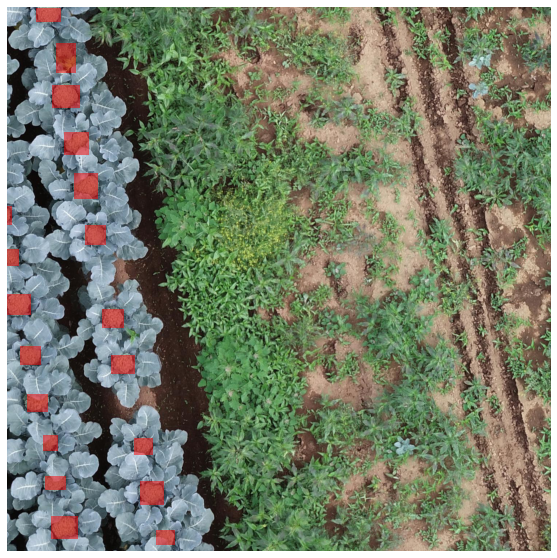

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

impath = f"Z:/共享云端硬盘/broccoliProject/anotation_use/jpg/{project_name}/{label_list[0][:-4]}.jpg"

ax.imshow(plt.imread(impath))

boxes = []
for i in range(len(bbox_demo)):
    rect = Rectangle((bbox_demo.x0.iloc[i], bbox_demo.y0.iloc[i]), 
                     bbox_demo.w.iloc[i], bbox_demo.h.iloc[i])
    boxes.append(rect)

pc = PatchCollection(boxes, facecolor='r', alpha=0.5)

ax.add_collection(pc)

ax.axis('off')

plt.show()

# remove duplicate

## add offset back

In [56]:
bbox['xc_dom'] = bbox['xc'] + bbox['offset_x']
bbox['yc_dom'] = bbox['yc'] + bbox['offset_y']
bbox['x0_dom'] = bbox['x0'] + bbox['offset_x']
bbox['x1_dom'] = bbox['x1'] + bbox['offset_x']
bbox['y0_dom'] = bbox['y0'] + bbox['offset_y']
bbox['y1_dom'] = bbox['y1'] + bbox['offset_y']

bbox['wh_ratio_div'] = np.abs(bbox['w'] / bbox['h'] - 1)
bbox['area'] = bbox['w'] * bbox['h']

bbox

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,y1,xc_dom,yc_dom,x0_dom,x1_dom,y0_dom,y1_dom,wh_ratio_div,area
0,16900,7800,7,574,14,53,0.424072,0,14,548,601,16907,8374,16900,16914,8348,8401,0.735849,742
1,16900,7800,162,140,53,82,0.642090,135,188,99,181,17062,7940,17035,17088,7899,7981,0.353659,4346
2,16900,7800,435,1463,53,40,0.646973,409,462,1443,1483,17335,9263,17309,17362,9243,9283,0.325000,2120
3,16900,7800,114,21,68,39,0.687988,80,148,1,40,17014,7821,16980,17048,7801,7840,0.743590,2652
4,16900,7800,82,1092,57,48,0.712891,54,111,1068,1116,16982,8892,16954,17011,8868,8916,0.187500,2736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9930,5200,15600,690,694,69,66,0.806641,655,724,661,727,5890,16294,5855,5924,16261,16327,0.045455,4554
9931,5200,15600,140,1012,71,61,0.809570,104,175,982,1043,5340,16612,5304,5375,16582,16643,0.163934,4331
9932,5200,15600,222,1398,55,46,0.811523,195,250,1375,1421,5422,16998,5395,5450,16975,17021,0.195652,2530
9933,5200,15600,588,219,71,65,0.816406,553,624,186,251,5788,15819,5753,5824,15786,15851,0.092308,4615


calculate the distance between each xc

In [57]:
from scipy.spatial.distance import cdist

In [58]:
dm = cdist(bbox[['xc_dom', 'yc_dom']], bbox[['xc_dom', 'yc_dom']])
dm

array([[    0.        ,   460.84813117,   986.66356981, ...,
        14362.40234083, 13381.33722765, 14103.37537613],
       [  460.84813117,     0.        ,  1350.87305103, ...,
        14749.13434748, 13754.33448045, 14479.58079504],
       [  986.66356981,  1350.87305103,     0.        , ...,
        14203.8654598 , 13278.34119911, 13986.10860819],
       ...,
       [14362.40234083, 14749.13434748, 14203.8654598 , ...,
            0.        ,  1234.5027339 ,   644.09316096],
       [13381.33722765, 13754.33448045, 13278.34119911, ...,
         1234.5027339 ,     0.        ,   742.56380197],
       [14103.37537613, 14479.58079504, 13986.10860819, ...,
          644.09316096,   742.56380197,     0.        ]])

In [59]:
dm.shape

(9935, 9935)

In [60]:
r, c = np.diag_indices_from(dm)
dm[r, c] = np.nan

dm = np.triu(dm)
dm[np.tril_indices(dm.shape[0], -1)] = np.nan

dm

array([[           nan,   460.84813117,   986.66356981, ...,
        14362.40234083, 13381.33722765, 14103.37537613],
       [           nan,            nan,  1350.87305103, ...,
        14749.13434748, 13754.33448045, 14479.58079504],
       [           nan,            nan,            nan, ...,
        14203.8654598 , 13278.34119911, 13986.10860819],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,  1234.5027339 ,   644.09316096],
       [           nan,            nan,            nan, ...,
                   nan,            nan,   742.56380197],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [61]:
dis = np.percentile(bbox[['w', 'h']], 99)
dis

81.31000000000131

In [62]:
r, c = np.where(dm <= dis)

dis_close = pd.DataFrame({'r':r, 'c':c, 'dis': dm[r,c]})
dis_close

,r,c,dis
0,0,2522,29.000000
1,1,245,2.000000
2,1,2195,1.000000
3,1,2510,1.000000
4,2,324,3.162278
...,...,...,...
3629,9788,9846,1.000000
3630,9802,9837,24.000000
3631,9808,9854,2.236068
3632,9824,9882,2.236068


## Remove trial 1

emmmm, it seems it will only remove small bbox rather than duplicated overalpping bbox, back to using NMS algorithm to remove duplicate.

In [63]:
close_id = pd.unique(pd.concat([dis_close.r, dis_close.c]))
close_id

array([   0,    1,    2, ..., 9837, 9854, 9880], dtype=int64)

In [64]:
close_id.shape

(5225,)

In [77]:
bbox['close_dis'] = False
bbox

,offset_x,offset_y,xc,yc,w,h,x0,x1,y0,y1,xc_dom,yc_dom,x0_dom,x1_dom,y0_dom,y1_dom,wh_ratio_div,close_dis,area
0,9100,11700,371,616,44,56,349,393,588,644,9471,12316,9449,9493,12288,12344,0.214286,False,2464
1,9100,11700,588,345,45,54,565,610,318,372,9688,12045,9665,9710,12018,12072,0.166667,False,2430
2,9100,11700,9,172,19,52,0,19,146,198,9109,11872,9100,9119,11846,11898,0.634615,False,988
3,9100,11700,220,16,79,28,181,260,2,30,9320,11716,9281,9360,11702,11730,1.821429,False,2212
4,9100,11700,1294,15,53,21,1268,1321,5,26,10394,11715,10368,10421,11705,11726,1.523810,False,1113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,10400,9100,1290,549,65,73,1257,1322,512,585,11690,9649,11657,11722,9612,9685,0.109589,False,4745
10202,10400,9100,925,137,62,68,894,956,103,171,11325,9237,11294,11356,9203,9271,0.088235,False,4216
10203,10400,9100,504,1163,61,78,473,534,1124,1202,10904,10263,10873,10934,10224,10302,0.217949,False,4758
10204,10400,9100,184,981,71,76,149,220,943,1019,10584,10081,10549,10620,10043,10119,0.065789,False,5396


In [78]:
bbox.loc[close_id, 'close_dis'] = True

In [79]:
bbox

,offset_x,offset_y,xc,yc,w,h,x0,x1,y0,y1,xc_dom,yc_dom,x0_dom,x1_dom,y0_dom,y1_dom,wh_ratio_div,close_dis,area
0,9100,11700,371,616,44,56,349,393,588,644,9471,12316,9449,9493,12288,12344,0.214286,False,2464
1,9100,11700,588,345,45,54,565,610,318,372,9688,12045,9665,9710,12018,12072,0.166667,True,2430
2,9100,11700,9,172,19,52,0,19,146,198,9109,11872,9100,9119,11846,11898,0.634615,True,988
3,9100,11700,220,16,79,28,181,260,2,30,9320,11716,9281,9360,11702,11730,1.821429,True,2212
4,9100,11700,1294,15,53,21,1268,1321,5,26,10394,11715,10368,10421,11705,11726,1.523810,True,1113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,10400,9100,1290,549,65,73,1257,1322,512,585,11690,9649,11657,11722,9612,9685,0.109589,True,4745
10202,10400,9100,925,137,62,68,894,956,103,171,11325,9237,11294,11356,9203,9271,0.088235,True,4216
10203,10400,9100,504,1163,61,78,473,534,1124,1202,10904,10263,10873,10934,10224,10302,0.217949,False,4758
10204,10400,9100,184,981,71,76,149,220,943,1019,10584,10081,10549,10620,10043,10119,0.065789,True,5396


In [81]:
bbox.w.mean() * bbox.h.mean()

3320.3740893502145

In [83]:
rm_id = (bbox.wh_ratio_div > 0.5) & (bbox.area < bbox.w.mean() * bbox.h.mean()) & close_dis
rm_id

0        False
1        False
2         True
3         True
4         True
         ...  
10201    False
10202    False
10203    False
10204    False
10205    False
Length: 10206, dtype: bool

In [85]:
rm_bbox = bbox[rm_id]
rm_bbox

,offset_x,offset_y,xc,yc,w,h,x0,x1,y0,y1,xc_dom,yc_dom,x0_dom,x1_dom,y0_dom,y1_dom,wh_ratio_div,close_dis,area
2,9100,11700,9,172,19,52,0,19,146,198,9109,11872,9100,9119,11846,11898,0.634615,True,988
3,9100,11700,220,16,79,28,181,260,2,30,9320,11716,9281,9360,11702,11730,1.821429,True,2212
4,9100,11700,1294,15,53,21,1268,1321,5,26,10394,11715,10368,10421,11705,11726,1.523810,True,1113
27,9100,11700,1184,698,62,33,1153,1215,681,714,10284,12398,10253,10315,12381,12414,0.878788,False,2046
60,7800,20800,1486,672,26,64,1473,1499,640,704,9286,21472,9273,9299,21440,21504,0.593750,True,1664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10112,10400,7800,15,1422,29,60,0,29,1392,1452,10415,9222,10400,10429,9192,9252,0.516667,True,1740
10115,10400,7800,897,20,68,40,863,931,0,40,11297,7820,11263,11331,7800,7840,0.700000,True,2720
10155,10400,9100,7,1285,14,54,0,14,1258,1312,10407,10385,10400,10414,10358,10412,0.740741,True,756
10156,10400,9100,15,123,16,70,7,23,88,158,10415,9223,10407,10423,9188,9258,0.771429,True,1120


In [88]:
keep_bbox = bbox[-rm_id]
keep_bbox

,offset_x,offset_y,xc,yc,w,h,x0,x1,y0,y1,xc_dom,yc_dom,x0_dom,x1_dom,y0_dom,y1_dom,wh_ratio_div,close_dis,area
0,9100,11700,371,616,44,56,349,393,588,644,9471,12316,9449,9493,12288,12344,0.214286,False,2464
1,9100,11700,588,345,45,54,565,610,318,372,9688,12045,9665,9710,12018,12072,0.166667,True,2430
5,9100,11700,28,279,43,43,7,50,257,300,9128,11979,9107,9150,11957,12000,0.000000,True,1849
6,9100,11700,535,1458,64,52,503,567,1432,1484,9635,13158,9603,9667,13132,13184,0.230769,True,3328
7,9100,11700,832,360,42,31,811,853,344,375,9932,12060,9911,9953,12044,12075,0.354839,False,1302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,10400,9100,1290,549,65,73,1257,1322,512,585,11690,9649,11657,11722,9612,9685,0.109589,True,4745
10202,10400,9100,925,137,62,68,894,956,103,171,11325,9237,11294,11356,9203,9271,0.088235,True,4216
10203,10400,9100,504,1163,61,78,473,534,1124,1202,10904,10263,10873,10934,10224,10302,0.217949,False,4758
10204,10400,9100,184,981,71,76,149,220,943,1019,10584,10081,10549,10620,10043,10119,0.065789,True,5396


## Remove trial 2

By nms method

In [65]:
dis_close

,r,c,dis
0,0,2522,29.000000
1,1,245,2.000000
2,1,2195,1.000000
3,1,2510,1.000000
4,2,324,3.162278
...,...,...,...
3629,9788,9846,1.000000
3630,9802,9837,24.000000
3631,9808,9854,2.236068
3632,9824,9882,2.236068


### calculate IoU of each pairs

In [67]:
bbox.iloc[12, :]

offset_x        16900.000000
offset_y         7800.000000
xc                375.000000
yc               1212.000000
w                  52.000000
h                  46.000000
thresh              0.757324
x0                349.000000
x1                401.000000
y0               1189.000000
y1               1235.000000
xc_dom          17275.000000
yc_dom           9012.000000
x0_dom          17249.000000
x1_dom          17301.000000
y0_dom           8989.000000
y1_dom           9035.000000
wh_ratio_div        0.130435
area             2392.000000
Name: 12, dtype: float64

In [68]:
bbox.iloc[12, :].xc

375.0

In [76]:
def calcu_iou(dis_close, bbox):
    iou_list = []
    for i in range(len(dis_close)):
        bb1_id = dis_close.r.iloc[i]
        bb2_id = dis_close.c.iloc[i]
        
        bbox1 = bbox.iloc[bb1_id, :]
        bbox2 = bbox.iloc[bb2_id, :]
        
        xx0 = max(bbox1.x0_dom, bbox2.x0_dom)
        yy0 = max(bbox1.y0_dom, bbox2.y0_dom)
        xx1 = min(bbox1.x1_dom, bbox2.x1_dom)
        yy1 = min(bbox1.y1_dom, bbox2.y1_dom)
        
        area1 = bbox1.area
        area2 = bbox2.area
        
        ww = max(0.0, xx1 - xx0 + 1)
        hh = max(0.0, yy1 - yy0 + 1)
        
        inter = ww * hh
        summed = area1 + area2 - inter

        iou_list.append(inter / summed)
        
    return iou_list

In [98]:
iou_list = calcu_iou(dis_close, bbox)
len(iou_list)

3634

## Using other func directly

In [78]:
def NMS(arr, thresh):
    # 首先数据赋值和计算对应矩形框的面积
    # arr的数据格式是arr = [[ xmin, ymin, xmax, ymax,scores]....]

    x1 = arr[:, 0]
    y1 = arr[:, 1]
    x2 = arr[:, 2]
    y2 = arr[:, 3]
    score = arr[:, 4]

    # 所有矩形框的面积
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # 取出分数从大到小排列的索引。.argsort()是从小到大排列，[::-1]是列表头和尾颠倒一下。
    order = score.argsort()[::-1]
    # 上面这两句比如分数score = [0.72 0.8  0.92 0.72 0.81 0.9 ]
    # 对应的索引order = [2, 5, 4, 1, 3, 0]记住是取出索引，scores列表没变。

    # 这边的keep用于存放，NMS后剩余的方框
    keep = []

    # order会剔除遍历过的方框，和合并过的方框
    while order.size > 0:
        # 取出第一个方框进行和其他方框比对，看有没有可以合并的，就是取最大score的索引
        i = order[0]

        # 因为我们这边分数已经按从大到小排列了。
        # 所以如果有合并存在，也是保留分数最高的这个，也就是我们现在那个这个
        # keep保留的是索引值，不是具体的分数。
        keep.append(i)

        # 计算交集的左上角和右下角
        # 这里要注意，比如x1[i]这个方框的左上角x和所有其他的方框的左上角x的
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # 这边要注意，如果两个方框相交，xx2-xx1和yy2-yy1是正的。
        # 如果两个方框不相交，xx2-xx1和yy2-yy1是负的，我们把不相交的w和h设为0.
        w = np.maximum(0, xx2-xx1+1)
        h = np.maximum(0, yy2-yy1+1)
        # 计算重叠面积就是上面说的交集面积。不相交因为W和H都是0，所以不相交面积为0
        inter = w * h

        # 这个就是IOU公式（交并比）。
        # 得出来的ious是一个列表，里面拥有当前方框和其他所有方框的IOU结果。
        ious = inter / (areas[i] + areas[order[1:]] - inter)

        # 接下来是合并重叠度最大的方框，也就是合并ious中值大于thresh的方框
        # 我们合并的操作就是把他们剔除，因为我们合并这些方框只保留下分数最高的。
        # 我们经过排序当前我们操作的方框就是分数最高的，所以我们剔除其他和当前重叠度最高的方框
        # 这里np.where(ious<=thresh)[0]是一个固定写法。
        index = np.where(ious <= thresh)[0]

        # 把留下来框在进行NMS操作
        # 这边留下的框是去除当前操作的框，和当前操作的框重叠度大于thresh的框
        # 每一次都会先去除当前操作框（n个框计算n-1个IOU值），所以索引的列表就会向前移动移位，要还原就+1，向后移动一位
        order = order[index+1]

    return keep

In [96]:
keep_id = NMS(bbox[['x0_dom', 'y0_dom', 'x1_dom', 'y1_dom', 'thresh']].to_numpy(), 0.0)

In [97]:
len(keep_id)

7078

In [100]:
bbox['keep'] = False

In [101]:
bbox.loc[keep_id, 'keep'] = True

In [102]:
bbox

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,...,xc_dom,yc_dom,x0_dom,x1_dom,y0_dom,y1_dom,wh_ratio_div,area,remove,keep
0,16900,7800,7,574,14,53,0.424072,0,14,548,...,16907,8374,16900,16914,8348,8401,0.735849,742,False,False
1,16900,7800,162,140,53,82,0.642090,135,188,99,...,17062,7940,17035,17088,7899,7981,0.353659,4346,False,False
2,16900,7800,435,1463,53,40,0.646973,409,462,1443,...,17335,9263,17309,17362,9243,9283,0.325000,2120,False,False
3,16900,7800,114,21,68,39,0.687988,80,148,1,...,17014,7821,16980,17048,7801,7840,0.743590,2652,False,False
4,16900,7800,82,1092,57,48,0.712891,54,111,1068,...,16982,8892,16954,17011,8868,8916,0.187500,2736,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9930,5200,15600,690,694,69,66,0.806641,655,724,661,...,5890,16294,5855,5924,16261,16327,0.045455,4554,False,True
9931,5200,15600,140,1012,71,61,0.809570,104,175,982,...,5340,16612,5304,5375,16582,16643,0.163934,4331,False,True
9932,5200,15600,222,1398,55,46,0.811523,195,250,1375,...,5422,16998,5395,5450,16975,17021,0.195652,2530,False,True
9933,5200,15600,588,219,71,65,0.816406,553,624,186,...,5788,15819,5753,5824,15786,15851,0.092308,4615,False,True


In [115]:
keep_bbox = bbox[bbox.keep]
keep_bbox

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,...,xc_dom,yc_dom,x0_dom,x1_dom,y0_dom,y1_dom,wh_ratio_div,area,remove,keep
5,16900,7800,16,691,32,48,0.719238,0,32,667,...,16916,8491,16900,16932,8467,8515,0.333333,1536,False,True
7,16900,7800,319,984,64,53,0.739258,287,351,958,...,17219,8784,17187,17251,8758,8811,0.207547,3392,False,True
9,16900,7800,191,375,70,62,0.752441,156,226,344,...,17091,8175,17056,17126,8144,8206,0.129032,4340,False,True
10,16900,7800,292,858,60,52,0.755371,262,322,832,...,17192,8658,17162,17222,8632,8684,0.153846,3120,False,True
11,16900,7800,119,1201,40,44,0.756836,99,139,1179,...,17019,9001,16999,17039,8979,9023,0.090909,1760,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9930,5200,15600,690,694,69,66,0.806641,655,724,661,...,5890,16294,5855,5924,16261,16327,0.045455,4554,False,True
9931,5200,15600,140,1012,71,61,0.809570,104,175,982,...,5340,16612,5304,5375,16582,16643,0.163934,4331,False,True
9932,5200,15600,222,1398,55,46,0.811523,195,250,1375,...,5422,16998,5395,5450,16975,17021,0.195652,2530,False,True
9933,5200,15600,588,219,71,65,0.816406,553,624,186,...,5788,15819,5753,5824,15786,15851,0.092308,4615,False,True


In [116]:
rm_bbox = bbox[-bbox.keep]
rm_bbox

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,...,xc_dom,yc_dom,x0_dom,x1_dom,y0_dom,y1_dom,wh_ratio_div,area,remove,keep
0,16900,7800,7,574,14,53,0.424072,0,14,548,...,16907,8374,16900,16914,8348,8401,0.735849,742,False,False
1,16900,7800,162,140,53,82,0.642090,135,188,99,...,17062,7940,17035,17088,7899,7981,0.353659,4346,False,False
2,16900,7800,435,1463,53,40,0.646973,409,462,1443,...,17335,9263,17309,17362,9243,9283,0.325000,2120,False,False
3,16900,7800,114,21,68,39,0.687988,80,148,1,...,17014,7821,16980,17048,7801,7840,0.743590,2652,False,False
4,16900,7800,82,1092,57,48,0.712891,54,111,1068,...,16982,8892,16954,17011,8868,8916,0.187500,2736,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9908,5200,15600,565,84,68,57,0.719727,531,599,56,...,5765,15684,5731,5799,15656,15713,0.192982,3876,False,False
9912,5200,15600,32,515,64,72,0.744629,0,64,479,...,5232,16115,5200,5264,16079,16151,0.111111,4608,False,False
9916,5200,15600,171,1139,61,64,0.770996,141,202,1107,...,5371,16739,5341,5402,16707,16771,0.046875,3904,False,False
9922,5200,15600,204,128,62,70,0.789062,173,235,93,...,5404,15728,5373,5435,15693,15763,0.114286,4340,False,False
